In [6]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications import ResNet50V2, InceptionV3, NASNetMobile
from tensorflow.keras.layers import *

# define the grand cam function
from tf_keras_vis.utils import normalize
from matplotlib import cm 
import matplotlib.pyplot as plt
from tf_keras_vis.gradcam import Gradcam
import os

In [12]:
# model_vgg16 = tf.keras.applications.vgg16.VGG16(
#     include_top=True,
#     weights='imagenet',
#     input_tensor=None,
#     input_shape=None,
#     pooling=None,
#     classes=1000,
#     classifier_activation='softmax'
# )

model = tf.keras.models.load_model('./Experiment/models/vending_3class_InceptionV3_30epoch_avg.h5')

In [37]:
model.layers[1].layers[0].tensor

AttributeError: 'InputLayer' object has no attribute 'tensor'

In [9]:
images_name_list = []
idx_final_layer =[]
class_names = ['Alu', 'Milk_box', 'PET']

for cls in os.listdir('./UEH_vending_test/'):
    for img in os.listdir(f'./UEH_vending_test/{cls}'):
        images_name_list.append(f'./UEH_vending_test/{cls}/{img}')
        idx_final_layer.append(class_names.index(cls))

images_cv2 = [cv2.cvtColor(cv2.resize(cv2.imread(img), (224,224)), cv2.COLOR_BGR2RGB) for img in images_name_list]
X = np.array(images_cv2, np.float32)


In [66]:
model.layers[2].summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [61]:
model.predict(X[:10])

1/1 [==============================] - 2s 2s/step


array([[0.3339606 , 0.3326473 , 0.3333921 ],
       [0.3340784 , 0.33280104, 0.33312055],
       [0.33278748, 0.33293676, 0.33427572],
       [0.33359322, 0.33311096, 0.33329582],
       [0.33278492, 0.33282357, 0.33439153],
       [0.3335051 , 0.3325122 , 0.3339827 ],
       [0.33385453, 0.3325963 , 0.3335492 ],
       [0.3339292 , 0.33226663, 0.3338042 ],
       [0.33353198, 0.3326951 , 0.33377293],
       [0.33414406, 0.3324227 , 0.33343318]], dtype=float32)

In [77]:

def return_heatmap(X, idx_final_layer, model):
    def loss(output):
        return tuple(output[i][idx] for (i, idx) in enumerate(idx_final_layer))

    def model_modifier(mdl):
        mdl.layers[-1].activation = tf.keras.activations.linear

    gradcam = Gradcam(model,
                    model_modifier=model_modifier,
                    clone=False)
    cam = gradcam(loss, X , penultimate_layer=-1 )# the layer befor the softmax
    cam = normalize(cam)
    heatmap = (cam*255).astype(np.uint8)

    return heatmap


heatmaps = return_heatmap(X[:10], idx_final_layer[:10], model)


In [78]:
heatmaps.shape
heatmaps_rgb = [cv2.applyColorMap(x , cv2.COLORMAP_JET) for x in heatmaps]
alpha = 0.5
images_cv_with_heatmap = [cv2.addWeighted(img, alpha, heat , 1-alpha, 0) for (heat, img) in zip(heatmaps_rgb, images_cv2)]

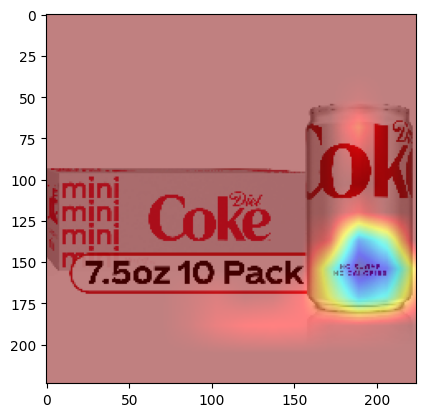

In [84]:
plt.imshow(images_cv_with_heatmap[5])

In [7]:

def Create_model(model_name, pooling):
    conv_base = model_name(weights='imagenet',
                      include_top=False,
                      input_shape=(224, 224, 3),
                      pooling=pooling,
                      input_tensor = None
                      )  # 3 = number of channels in RGB pictures
    conv_base.trainable = False


    input = Input(shape=(224, 224, 3))
    x = Rescaling(1./255)(input)

    conv_base = model_name(weights='imagenet',
                      include_top=False,
                      input_shape=(224, 224, 3),
                      pooling=pooling,
                      input_tensor = x
                      )  # 3 = number of channels in RGB pictures
    conv_base.trainable = True

    x = Dropout(0.8)(conv_base.output)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.8)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.7)(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(3, activation='softmax')(x)

    model = tf.keras.Model(input, x)

    # Compile model
    model.compile(optimizer="adam",
                  loss='categorical_crossentropy',
                  metrics=['acc'])
    return model


model = Create_model(ResNet50V2, 'avg')

94668760/94668760 [==============================] - 13s 0us/step


In [8]:
model.load_weights('./Experiment/models/vending_3class_ResNet50V2_30epoch_avg.h5')

ValueError: Layer count mismatch when loading weights from file. Model expected 106 layers, found 5 saved layers.

In [76]:
a = np.random.rand(1,224,224,3)
model(a)

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.33214068, 0.3337941 , 0.3340652 ]], dtype=float32)>

In [50]:
model = tf.keras.Sequential(
    [
        Input(shape=(224,224,3)),
        Multiply()[],
        tf.keras.applications.vgg16.VGG16(
            include_top=True,
            weights='imagenet',
            input_tensor=None,
            input_shape=None,
            pooling=None,
            classes=1000,
            classifier_activation='softmax'
        ),
        Dense(3, activation="relu", name="layer2"),
    ]
)